## Probability Calibration in ML

Here we will simply illustrate how to calibrate binary classification data for structured data predictions. We will use a dataset consisting of 30×30m patches of forest collected for the task of predicting each patch’s cover type, i.e. the dominant species of tree. There are seven covertypes, making this a multiclass classification problem. Each sample has 54 features, described on the dataset’s [homepage](https://archive.ics.uci.edu/ml/datasets/Covertype). Some of the features are boolean indicators, while others are discrete or continuous measurements.

The dataset is available to download directly with `scikit-learn`. We will start by simplifying the data set for a binary classification, and will leave it as exercise to do multiclass for you!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's get our data set, and normalize it with standard scaling

In [ ]:
from sklearn.datasets import fetch_covtype
from sklearn.utils import check_array
from sklearn.model_selection import train_test_split


def get_forest_data(dtype=np.float32, order='C', random_state=13):

    data = fetch_covtype(download_if_missing=True,
                         shuffle=True,
                         random_state=random_state)
    X = check_array(data['data'], dtype=dtype, order=order)

    #  make it binary classification
    y = (data['target'] != 1).astype(np.int)

    # hardcode training set size like original paper Joachim 2006
    n_train = 522911
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    
    # normalize first 10 features (the numerical ones)
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    mean[10:] = 0.0
    std[10:] = 1.0
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_forest_data()

<ipython-input-2-e58711f3e14f>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (data['target'] != 1).astype(np.int)


In [ ]:
print(X_train.shape, y_train.shape)
# subsample training set by a factor of 10, to make training faster.
X_train = X_train[::10]
y_train = y_train[::10]

(522911, 54) (522911,)


In [ ]:
# handy plotting routine

from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Fraction of positives")

    ax.set(aspect='equal')
    return curve

Now let's fit 2 different models:
- Logistic Regression with integrated cross-validation
- Random Forest.

We expect the Logistic Regression predicted probabilities to behave like proper probabilities by construction. RF does not have such garanty.

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

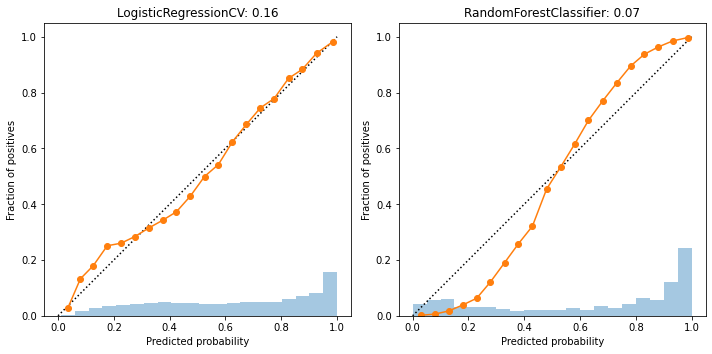

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

for ax, clf in zip(axes, [LogisticRegressionCV(),
                          RandomForestClassifier()]):
        scores = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        plot_calibration_curve(y_test, scores, n_bins=20, ax=ax)
        ax.set_title("{}: {:.2f}".format(clf.__class__.__name__, brier_score_loss(y_test, scores)))

plt.tight_layout()

Let's now take a deeper look at the Random Forest case and try to calibrate it.

/usr/local/lib/python3.9/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


Text(0.5, 1.0, 'RandomForestClassifier: 0.077')

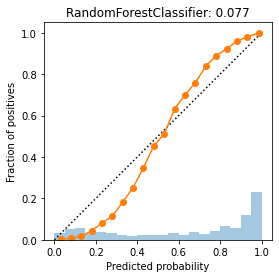

In [ ]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train,
                                                          stratify=y_train,
                                                          random_state=0)
rf = RandomForestClassifier().fit(X_train_sub, y_train_sub)
scores = rf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, scores, n_bins=20)
plt.title("{}: {:.3f}".format(clf.__class__.__name__, brier_score_loss(y_test, scores)))

You can use the `CalibratedClassifierCV` module directly. This would give you ways to calibrate the non-calibrated algorithms such as RF. 
A good explanation is on the scikit-learn developer [blog](https://jmetzen.github.io/2015-04-14/calibration.html).

Here we try the two methods to calibrate: with the simple sigmoid which is basically a logistic regression and with the isotonic mapping.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

cal_rf = CalibratedClassifierCV(rf, cv="prefit", method='sigmoid')
cal_rf.fit(X_val, y_val)
scores_sigm = cal_rf.predict_proba(X_test)[:, 1]

cal_rf_iso = CalibratedClassifierCV(rf, cv="prefit", method='isotonic')
cal_rf_iso.fit(X_val, y_val)
scores_iso = cal_rf_iso.predict_proba(X_test)[:, 1]

We want to use either use hold-out test set or cross-validation for calibrating our probabilities.
Cross-validation can be used to make unbiased probability predictions, use that as training set. Above, we use a "prefit" model and calibrate on the validation set.

/usr/local/lib/python3.9/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly no

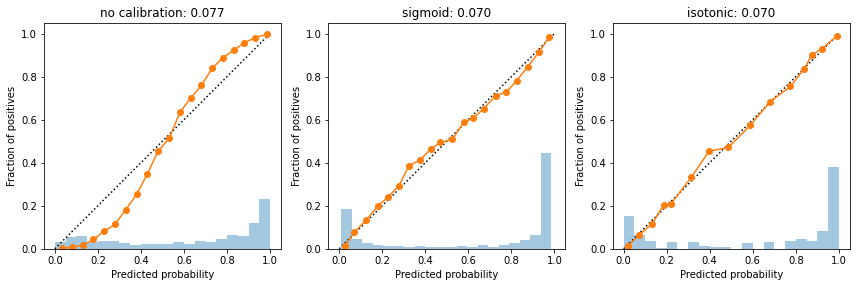

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for name, s, ax in zip(['no calibration', 'sigmoid', 'isotonic'],
                       [scores, scores_sigm, scores_iso], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()

For more examples and fancy plotting, check the [scikit-learn documentation](http://scikit-learn.org/dev/auto_examples/calibration/plot_calibration_multiclass.html) for a good example on multi-class calibration.

# Temperature Scaling Calibration with PyTorch

The rest of this notebooks delves into exploration of neural network uncertainty. It shows how networks tend to be overconfident and how we can mitigate with Temperature Scaling.See this [paper](https://arxiv.org/abs/1706.04599) for explaining the background.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Use the GPU provided by Google Colab
device = 'cuda:0'

# Allow reproducability
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Normalize the images by the imagenet mean/std since the nets are pretrained
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=True,
                                       download=True,
                                       transform=transform)

train_set, val_set = torch.utils.data.random_split(dataset, [45000, 5000])

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=128,
                                         shuffle=True,
                                         num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transform)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
num_classes = 10
net = models.resnet101(pretrained=True)
net.fc = nn.Linear(2048, num_classes)
net = net.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

RuntimeError: ignored

In [ ]:
# Training loop
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm

NUM_EPOCHS = 2

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    print(f'Training iteration {epoch}')
    for i, data in enumerate(tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

    corrects = []
    net.eval()
    classified_right = 0
    print('Evaluating on validation set')
    for i, data in enumerate(tqdm(val_loader, 0)):
        with torch.no_grad():
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = net(inputs)
          _, pred_classes = torch.max(outputs, 1)

          loss = criterion(outputs, labels)
          classified_right += (pred_classes == labels).sum().item()
          
    acc = classified_right / len(val_set)

    print(f'Epoch {epoch}  Acc: {acc}')


In [ ]:
################### Testing ######################

from tqdm.notebook import tqdm

# Use kwags for calibration method specific parameters
def test(calibration_method=None, **kwargs):
  preds = []
  labels_oneh = []
  correct = 0
  net.eval()
  with torch.no_grad():
      for data in tqdm(test_loader):
          images, labels = data[0].to(device), data[1].to(device)

          pred = net(images)
          
          if calibration_method:
            pred = calibration_method(pred, kwargs)

          # Get softmax values for net input and resulting class predictions
          sm = nn.Softmax(dim=1)
          pred = sm(pred)

          _, predicted_cl = torch.max(pred.data, 1)
          pred = pred.cpu().detach().numpy()

          # Convert labels to one hot encoding
          label_oneh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
          label_oneh = label_oneh.cpu().detach().numpy()

          preds.extend(pred)
          labels_oneh.extend(label_oneh)

          # Count correctly classified samples for accuracy
          correct += sum(predicted_cl == labels).item()

  preds = np.array(preds).flatten()
  labels_oneh = np.array(labels_oneh).flatten()

  correct_perc = correct / len(test_set)
  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct_perc))
  print(correct_perc)
  
  return preds, labels_oneh

preds, labels_oneh = test()

In [ ]:
def calc_bins(preds):
  # Assign each prediction to a bin
  num_bins = 10
  bins = np.linspace(0.1, 1, num_bins)
  binned = np.digitize(preds, bins)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
      bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

  return bins, binned, bin_accs, bin_confs, bin_sizes



# Visualizations and metrics

The Reliability Diagram as figured below intuitively show the relation between expected sample accuracy per bin and confidence.

$acc(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbf{1}(\hat{y}_i = y_i)$

$conf(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \hat{p}_i$

For the figure I chose $M=10$, describing the number of seperate bins where the predictions are put in their respective bin based on their magnitude ($Bin 1 = [0.0, 0.1), Bin 2 = [0.1, 0.2), ...)$).

For a perfectly calibrated model is defined as $P(\hat{Y} = Y | \hat{P} = p) = p, \forall p \in [0, 1]$. For Example: Given 100 predictions, each with confidence of 0.8, we expect 80 to be correctly classified. Bars under the identity line show underconfident behavior while bars above it signal overconfidence.


The Expected Calibration Error (ECE) is taking the weighted average of the bins' accuracy/cofidence differences.

$ECE = \sum_{m=1}^{M} \frac{|B_m|}{n} |acc(B_m) - conf(B_m)|$

The Maximum Calibration Error (MCE) focuses more on high risk applications where the maximum accuracy/confidence difference is more important than just the average.

$MCE = \max_m |acc(B_m) - conf(B_m)|$

In [ ]:
def get_metrics(preds):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE

In [ ]:
import matplotlib.patches as mpatches

def draw_reliability_graph(preds):
  ECE, MCE = get_metrics(preds)
  bins, _, bin_accs, _, _ = calc_bins(preds)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  # x/y limits
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1)

  # x/y labels
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  # Create grid
  ax.set_axisbelow(True) 
  ax.grid(color='gray', linestyle='dashed')

  # Error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
  ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  plt.legend(handles=[ECE_patch, MCE_patch])

  #plt.show()
  
  plt.savefig('calibrated_network.png', bbox_inches='tight')

#draw_reliability_graph(preds)


In [ ]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)

# Temperature Scaling

Temperature Scaling is a parametric calibration approach on the validation set using the Negative-Log-Likelihood (NLL) los. It learns a single parameter $T$ for all classes to update the confidences to $\hat{q}_i = max_k  \sigma_{SM}(z_i/T)^{(k)}$



More sample code can be found in [this](https://github.com/gpleiss/temperature_scaling) awesome GitHub repository by "gpleis".

In [ ]:
temperature = nn.Parameter(torch.ones(1).cuda())
args = {'temperature': temperature}
criterion = nn.CrossEntropyLoss()

# Removing strong_wolfe line search results in jump after 50 epochs
optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []
temps = []
losses = []

for i, data in enumerate(tqdm(val_loader, 0)):
    images, labels = data[0].to(device), data[1].to(device)

    net.eval()
    with torch.no_grad():
      logits_list.append(net(images))
      labels_list.append(labels)

# Create tensors
logits_list = torch.cat(logits_list).to(device)
labels_list = torch.cat(labels_list).to(device)

def _eval():
  loss = criterion(T_scaling(logits_list, args), labels_list)
  loss.backward()
  temps.append(temperature.item())
  losses.append(loss)
  return loss


optimizer.step(_eval)

print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

plt.subplot(121)
plt.plot(list(range(len(temps))), temps)

plt.subplot(122)
plt.plot(list(range(len(losses))), losses)
plt.show()



In [ ]:
preds_original, _ = test()
preds_calibrated, _ = test(T_scaling, temperature=temperature)

draw_reliability_graph(preds_original)
draw_reliability_graph(preds_calibrated)